In [43]:
import numpy as np

def read_input_file(file_path):
  with open(file_path, 'r') as file:
    lines = [line for line in file if not line.startswith('#')]
    m = float(lines[0].strip())
    C = float(lines[1].strip())
    x0 = float(lines[2].strip())
  return m, C, x0

#m, C, x0 = read_input_file('ex2-input.txt')

m = 1000 # Mass of the particle
C = 1500 * 12137804.1108138 * 5.29177210903e-11
x0 = (100/(m*C)**0.5)**0.5 # Initial position

L = 5.0  # Length of the system
T = 2000.0  # Time of the simulation
dx = 0.05  # Spatial step size
dt = 10  # Time step size

# Initial wave function
def psi0(x, C, x0):
    w = (C/m)**0.5
    return ((m * w / np.pi)**0.25) * np.exp(-0.5 * m * w * (x - x0)**2)

# Potential function
def potential(x, x0, C):
    return 0.5 * C * (np.abs(x) - x0)**2

# Split operator method
def split_operator(x0, C, dx, dt):
    x = np.arange(-L, L, dx, dtype=complex)
    N = len(x)
    # Initialize wave function
    psi = psi0(x, C, x0)
    Psi = []
    t = 0.0 # Initialize time
    while t < T:
        Psi.append((t, psi))
        # Kinetic evolution
        psi = np.exp(-0.5j * dt * (np.fft.fftfreq(N, dx) ** 2) / m) * np.fft.fft(psi)
        
        # Potential evolution
        psi *= np.exp(-1j * dt * potential(x, x0, C))
        
        # Kinetic evolution
        psi = np.exp(-0.5j * dt * (np.fft.fftfreq(N, dx) ** 2) / m) * np.fft.ifft(psi)
        
        # Update time
        t += dt
    return Psi

# Split operator method
def split_operator_mod(x0, C, dx, dt):
    x = np.arange(-L, L, dx, dtype=complex)
    N = len(x)
    # Initialize wave function
    psi = psi0(x, C, x0)
    Psi = []
    t = 0.0 # Initialize time
    while t < T:
        Psi.append((t, psi))
        # potential evolution
        psi *= np.exp(-0.5j * dt * potential(x, x0, C) / 2)
        
        # fast fourier transform
        psi = np.fft.fftn(psi)

        # kinetic evolution
        psi *= np.exp(-0.5j * dt * (np.fft.fftfreq(N, dx) ** 2) / m)
        
        # inverse fast fourier transform
        psi = np.fft.ifftn(psi)

        # potential evolution
        psi *= np.exp(-0.5j * dt * potential(x, x0, C) / 2)
        
        # Update time
        t += dt
    return Psi

Psi = split_operator_mod(x0, C, dx, dt)

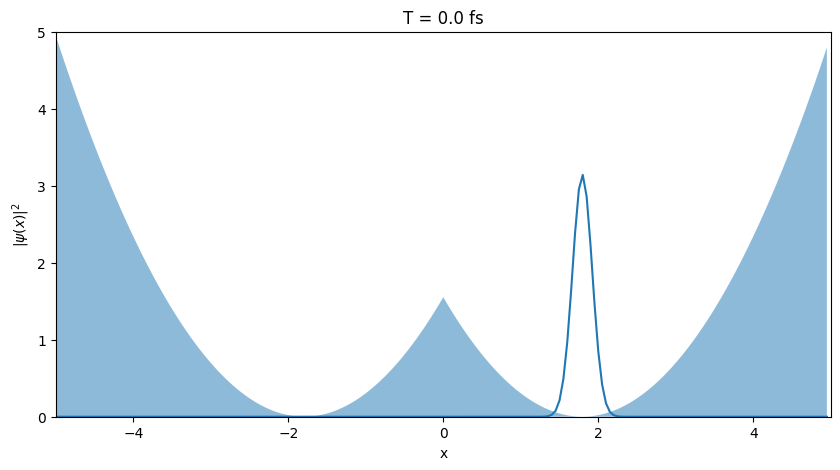

In [44]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

def animate(i):
    x = np.arange(-L, L, dx)
    ax.clear()
    fig.set_size_inches(10, 5)
    ax.set_xlim(-L, L)
    ax.set_ylim(0, 5)
    ax.plot(x, np.abs(Psi[i][1])**2)
    # plot the potential as a semi-transparent patch
    ax.fill_between(x, 0, potential(x, x0, C), alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('$|\psi(x)|^2$')
    ax.set_title('T = %.1f fs' % (Psi[i][0]))

ani = FuncAnimation(fig, animate, frames=len(Psi), interval=dt/1000)
# Save animation as a GIF file
ani.save('ex4.gif', writer='pillow')
